### Import modules

In [1]:
import networkx as nx

from agents import doubling_agent, local_ts_agent, local_ucb_agent,UCRL2_agent,QL_agent,QL_UCB_Hoeffding
from graph_bandit_helper_tools import return_graph,draw_graph
from core import train_agent

import numpy as np
from functools import partial
from time import time

import pickle as pkl

from matplotlib import pyplot as plt
import seaborn as sns

import random

%load_ext autoreload
%autoreload 2

SEED = 181731

In [8]:
# def doubling_agent(env):
#     ucb = get_ucb(env)
#     # Compute optimal policy.
#     policy,_,_ = offline_SP_planning(env.G,ucb)

#     # Travel to the node with the highest UCB
#     while ucb[env.state] < np.max(ucb):
#         next_s = policy[env.state]
#         env.step(next_s)

#     target_count = 0+env.nodes[env.state]['n_visits']
#     # Keep sampling the best UCB node until its number of samples doubles
#     for _ in range(target_count):
#         env.step(env.state)
# def UCRL2_agent(env,delta = 0.01):
    
#     ucb = UCRL2_ucb(env,delta = delta)
    
#     tm = len(env.visitedStates)
#     epsilon = 1/np.sqrt(tm) # The stopping condition of value iteration as specified in Jacksch(2008).
    
#     # Compute the policy.
#     policy,_ = EVI_known_transition_planning(env.G,ucb,epsilon = epsilon)
    
#     prev_visits = {s:env.nodes[s]['n_visits'] for s in env.G}
#     visits_this_episode = {s:0 for s in env.G}
    
#     # Keep executing the policy until the doubling terminal condition specified in Jacksh(2008) is meet.
#     while visits_this_episode[env.state]< np.max([1,prev_visits[env.state]]):
#         visits_this_episode[env.state]+=1
#         next_s = policy[env.state]
#         env.step(next_s)
        
from agents import get_ucb,UCRL2_ucb

from known_rewards_helper_functions import offline_SP_planning, EVI_known_transition_planning

def UCB_Doubling_agent(env,delta = 0.01, UCB = 'G-UCB', offline_planning = 'G-UCB', doubling = 'G-UCB'):
    '''
        The general agent that morphs between our algorithm and the UCRL2 algorithm
    '''
    # print(UCB,offline_planning,doubling)
    
    # Possible Difference 1: The definition of UCB.
    if UCB == 'G-UCB':
        ucb = get_ucb(env)
    elif UCB == 'UCRL2':
        ucb = UCRL2_ucb(env,delta = delta)
    else:
        assert(False)
    
    # Possible Difference 2: Offline Planning Algorithm
    
    if offline_planning == 'G-UCB':
        # Compute optimal policy.
        policy,_,_ = offline_SP_planning(env.G,ucb)
    elif offline_planning == 'UCRL2':
        # print('UCRL2 planning')
        tm = len(env.visitedStates)
        epsilon = 1/np.sqrt(tm) # The stopping condition of value iteration as specified in Jacksch(2008).
        policy,_ = EVI_known_transition_planning(env.G,ucb,epsilon = epsilon)
    else:
        assert(False)
    
    # Possible Difference 3: The doubling scheme
    if doubling == 'G-UCB':
        # We need to ensure the true optimal policy is used, so that the agent can reach the destination state.
        assert(offline_planning == 'G-UCB') 
        
        # Travel to the node with the highest UCB
        while ucb[env.state] < np.max(ucb):
            next_s = policy[env.state]
            env.step(next_s)

        target_count = 0+env.nodes[env.state]['n_visits']
        # Keep sampling the best UCB node until its number of samples doubles
        for _ in range(target_count):
            env.step(env.state)
            
    elif doubling == 'UCRL2':
        prev_visits = {s:env.nodes[s]['n_visits'] for s in env.G}
        visits_this_episode = {s:0 for s in env.G}

        # Keep executing the policy until the doubling terminal condition specified in Jacksh(2008) is meet.
        while visits_this_episode[env.state]< np.max([1,prev_visits[env.state]]):
            visits_this_episode[env.state]+=1
            next_s = policy[env.state]
            env.step(next_s)
    else:
        assert(False)

In [19]:
def plotRegrets(line_regret, titles=None, save_fig=None):
    """
    agents: A list of dictionaries. Each dictionary contains the configuration of a run and the corresponding regret.
    """
    sns.set()
    
    for name,regret in line_regret.items():
        regret = np.cumsum(regret, axis=1)
        regret = np.mean(regret, axis=0)
        sd = np.std(regret,axis=0)

        
        # plt.plot([i for i in range(1,len(regret)+1)],regret, label=label,\
                # linewidth=3)
            
        plot_every = int(len(regret)/7)
         
        plt.errorbar(range(1,len(regret)+1), regret ,sd,errorevery=plot_every,\
                     label=name,linewidth=3,\
                    capsize=5,elinewidth=3)
            
    if titles is not None:    
        plt.title(titles[0])
            
    plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.45), fontsize=16)
    plt.xlabel('$t$', fontsize=20)
    plt.ylabel('Expected regret', fontsize=20)
    plt.tick_params(labelsize=20)
    plt.style.use('seaborn-dark-palette')
    plt.show()

### Define parameters

Define the following parameters:  
$\texttt{T}:$ game length  
$\texttt{n_samples}:$ number of games to run   
$\texttt{episodes}:$ number of episodes; Let this be 1 for now 
$\texttt{n_nodes}:$ number of nodes in graph. 
$\texttt{mu_size}:$ the node means are drawn as $\mu\sim \texttt{mu_size}\times \mathcal{N}(0,1)$   
$\texttt{sigma_size}:$ the node standard deviations are set to $\texttt{sigma_size}$ 
$\texttt{epsilon}:$ exploration parameter (only applicable for Q-learning algorithms)  
$\texttt{epsilon_discount}:$ exploration discount parameter (only applicable for Q-learning algorithms)  
$\texttt{algorithms}:$ the algorithms to run. 


 



In [11]:
n_samples = 20

init_node = 0

# The effect of UCB

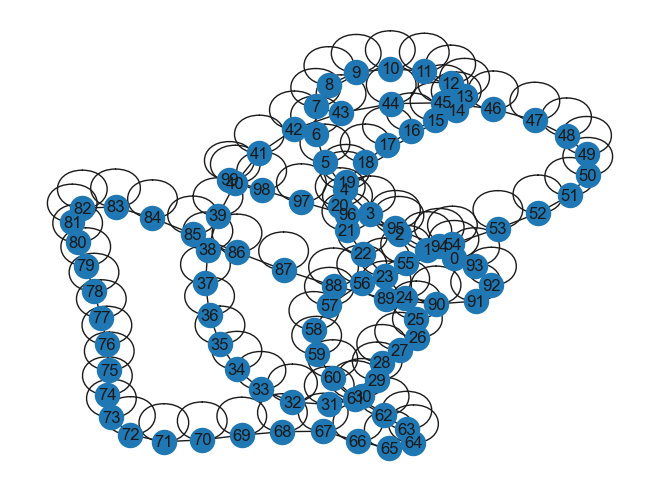

/Users/tianpengzhang/Dropbox (Harvard University)/Tianpeng's research/Tianpeng & Lina/GraphBandit/Graph-Bandit/known_rewards_helper_functions.py:75: UserWarning: Value iteration terminated before reaching the stopping condition, the resulting policy may be suboptimal.
  warnings.warn('Value iteration terminated before reaching the stopping condition, the resulting policy may be suboptimal.')
/Users/tianpengzhang/Dropbox (Harvard University)/Tianpeng's research/Tianpeng & Lina/GraphBandit/Graph-Bandit/known_rewards_helper_functions.py:75: UserWarning: Value iteration terminated before reaching the stopping condition, the resulting policy may be suboptimal.
  warnings.warn('Value iteration terminated before reaching the stopping condition, the resulting policy may be suboptimal.')
/Users/tianpengzhang/Dropbox (Harvard University)/Tianpeng's research/Tianpeng & Lina/GraphBandit/Graph-Bandit/known_rewards_helper_functions.py:75: UserWarning: Value iteration terminated before reaching the s

Run time for G-UCB-UCRL2-UCRL2: 8.075554132461548
Run time for UCRL2-UCRL2-UCRL2: 10.759975910186768


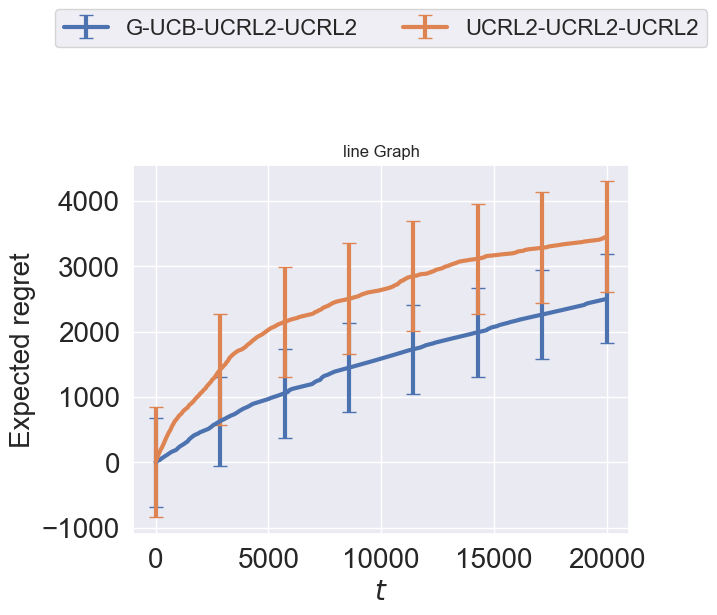

Total run time: 18.924467086791992


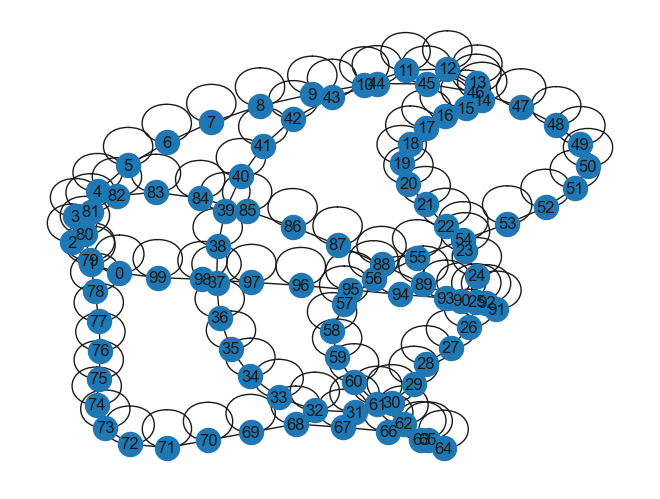

Run time for G-UCB-UCRL2-UCRL2: 8.083836078643799
Run time for UCRL2-UCRL2-UCRL2: 11.933712720870972


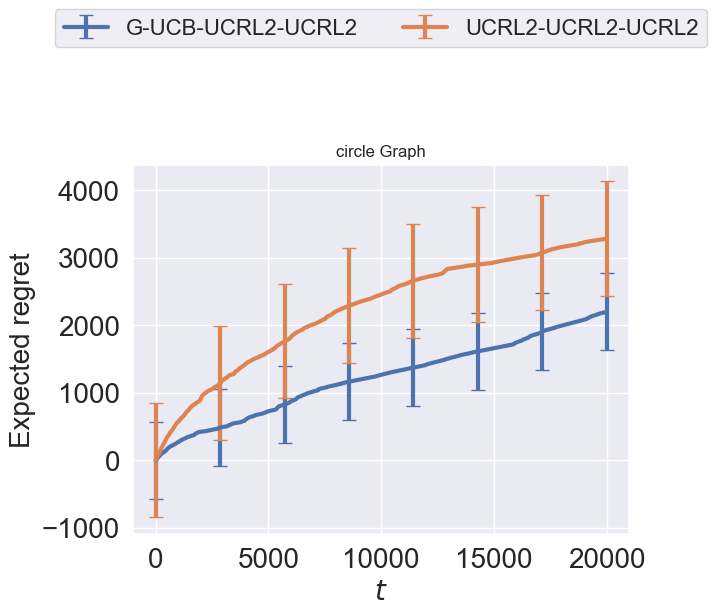

Total run time: 20.105668783187866


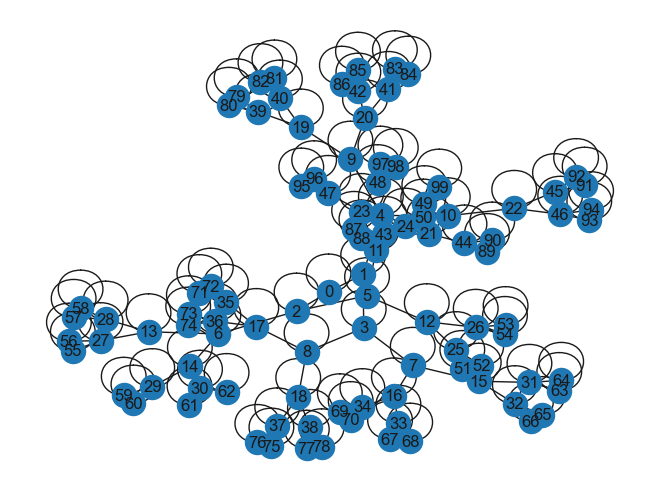

Run time for G-UCB-UCRL2-UCRL2: 9.41504168510437
Run time for UCRL2-UCRL2-UCRL2: 16.8629629611969


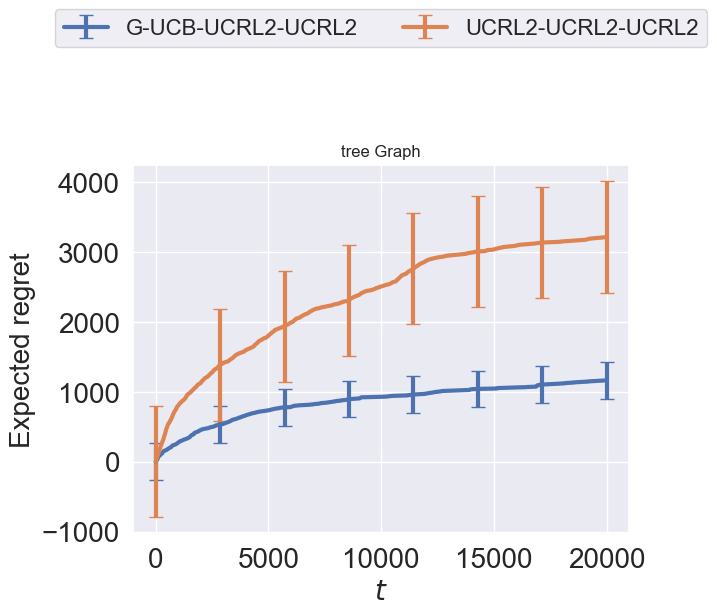

Total run time: 26.375779151916504


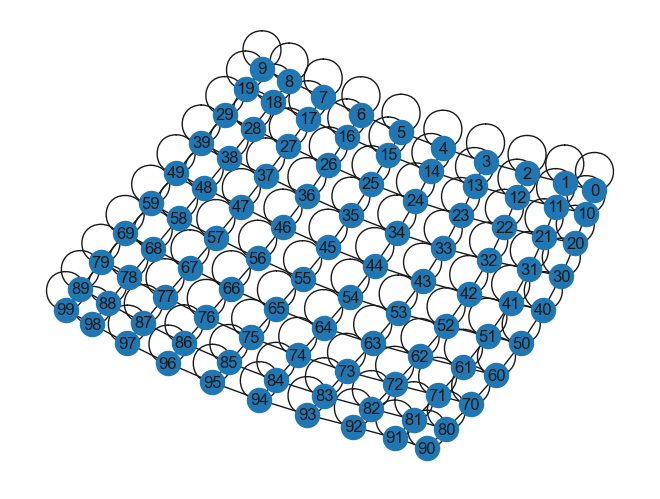

Run time for G-UCB-UCRL2-UCRL2: 8.078212261199951
Run time for UCRL2-UCRL2-UCRL2: 14.238096952438354


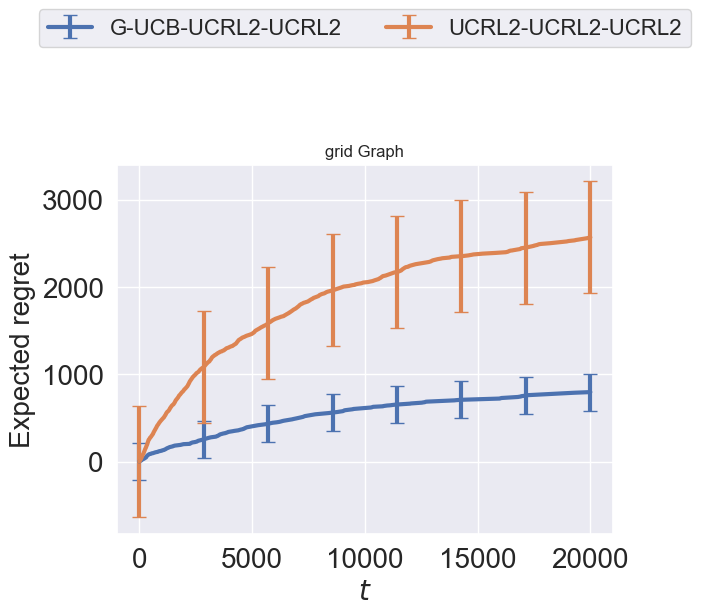

Total run time: 22.406094074249268


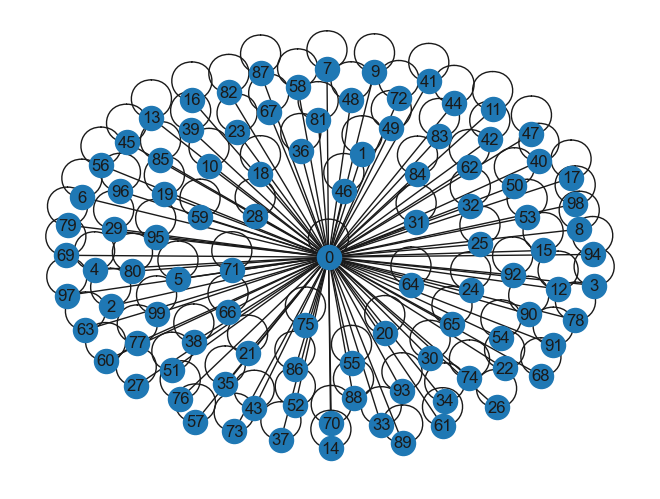

Run time for G-UCB-UCRL2-UCRL2: 10.076112031936646
Run time for UCRL2-UCRL2-UCRL2: 20.805460929870605


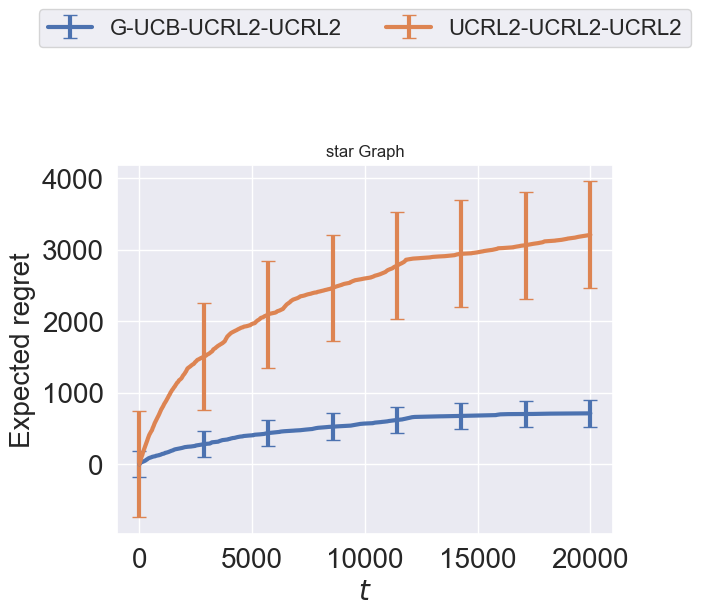

Total run time: 30.968389987945557


In [23]:
graph_types = ['line','circle','tree','grid','star']
# graph_types = ['line']
# T = 20000
T = 20000
n_nodes = 100

algs = ['G-UCB','UCRL2']
agents = []
# for ucb_alg in algs:
#     for planning_alg in algs:
#         for doubling_alg in algs:
#             if doubling_alg == 'G-UCB' and planning_alg == 'UCRL2':
#                 # We need to ensure the true optimal policy is used, so that the agent can reach the destination state.
#                 continue
#             else:
#                 agents.append(
#                     {'UCB':ucb_alg,
#                      'Offline Planning':planning_alg,
#                      'Doubling':doubling_alg,
#                     } 
#                 )

# agents = [{'UCB':alg,'Offline Planning':'G-UCB','Doubling':'G-UCB'} for alg in algs]

agents = [{'UCB':alg,'Offline Planning':'UCRL2','Doubling':'UCRL2'} for alg in algs]
for profile in agents:
    profile['agent']= partial(UCB_Doubling_agent,UCB=profile['UCB'],offline_planning = profile['Offline Planning'], doubling=profile['Doubling'])

            
for graph in graph_types:
    
    np.random.seed(SEED)
    random.seed(SEED)
    G = return_graph(graph, n_nodes)
    draw_graph(G)

    np.random.seed(SEED)
    random.seed(SEED)
    means = np.random.uniform(low=0.5,high=9.5,size=(n_samples,n_nodes))

    t0 = time()
    line_regrets = {}
    for alg_profile in agents:
        t = time()
        
        name = '{}-{}-{}'.format(alg_profile['UCB'],alg_profile['Offline Planning'],alg_profile['Doubling'])
        
        line_regrets[name] = train_agent(n_samples,T,G,means, init_node,alg_profile['agent'],parallelized=True)
        
        print('Run time for {}:'.format(name),time()-t)

    with open('Data/{}_vsUCRL2.pkl'.format(graph), 'wb') as file:
        pkl.dump(line_regrets,file)
        
    plt.figure(dpi=100)
    plotRegrets(line_regrets,titles=['{} Graph'.format(graph)])
    

    print('Total run time:', time()-t0)
    
